In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.correlation_tools import cov_nearest

def compute_compound_cov(p, ρ, σ):
    Σ_compound = np.diag(np.ones(p))
    mask_off_dia = ~np.eye(Σ_compound.shape[0], dtype=bool)
    print(mask_off_dia)
    Σ_compound[mask_off_dia] = -25
    Σ_compound = σ**2 * Σ_compound
    Σ_compound = cov_nearest(Σ_compound)
    return Σ_compound
compute_compound_cov(10, 10, 1)

[[False  True  True  True  True  True  True  True  True  True]
 [ True False  True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True]
 [ True  True  True False  True  True  True  True  True  True]
 [ True  True  True  True False  True  True  True  True  True]
 [ True  True  True  True  True False  True  True  True  True]
 [ True  True  True  True  True  True False  True  True  True]
 [ True  True  True  True  True  True  True False  True  True]
 [ True  True  True  True  True  True  True  True False  True]
 [ True  True  True  True  True  True  True  True  True False]]


array([[ 1.        , -0.11111111, -0.11111111, -0.11111111, -0.11111111,
        -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [-0.11111111,  1.        , -0.11111111, -0.11111111, -0.11111111,
        -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [-0.11111111, -0.11111111,  1.        , -0.11111111, -0.11111111,
        -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [-0.11111111, -0.11111111, -0.11111111,  1.        , -0.11111111,
        -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [-0.11111111, -0.11111111, -0.11111111, -0.11111111,  1.        ,
        -0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [-0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111,
         1.        , -0.11111111, -0.11111111, -0.11111111, -0.11111111],
       [-0.11111111, -0.11111111, -0.11111111, -0.11111111, -0.11111111,
        -0.11111111,  1.        , -0.11111111

In [10]:
@numba.njit(cache=True, fastmath=True, nogil=True)
def generate_orthonormal_matrix(dim, seed=None):
    """
    Generate random orthonormal matrix of size dim x dim.
    """
    a = np.ones((dim, dim))
    res, _ = np.linalg.qr(a)
    return np.ascontiguousarray(res)


@numba.njit(cache=True, fastmath=True, nogil=True)
def generate_orthonormal_matrix_large_a(dim, seed=None):
    """
    Generate random orthonormal matrix of size dim x dim.
    """

    np.random.seed(seed+1)
    a = np.random.uniform(10, 50, (dim, dim))
    res, _ = np.linalg.qr(a)
    return np.ascontiguousarray(res)

def phi_abs(t):
    """
    Purely nonlinear activation function used in Hastie et al. (2022).

    Formula:
    $\varphi_{\mathrm{abs}}(t)=a(|t|-b)$

    where $a=\sqrt{\pi /(\pi-2)} \text { and } b=\sqrt{2 / \pi}$.
 
    Returns
    -------
    phi_abs : function
        Absolute value activation function.
    """

    a = np.sqrt(np.pi / (np.pi - 2))
    b = np.sqrt(2 / np.pi)
    return a * (np.abs(t) - b)

def compute_X(λ, μ, n, p, ϕ, seed=None):
    """
    Generate X = Γ Z C, where Z is a n x p matrix of iid standard normal
    random variables;

    Γ is a n x n matrix with eigenvalues (μ, 1, ..., 1);

    C is a p x p matrix with eigenvalues (λ, 1, ..., 1).
    """

    U = generate_orthonormal_matrix(p)
    V = generate_orthonormal_matrix(n)

    Λ = np.diag(np.concatenate((np.array([λ]), np.ones(p-1))))
    C = ((U @ Λ) @ U.T).real
    A = np.diag(np.concatenate((np.array([μ]), np.ones(n-1))))
    Γ = ((V @ A) @ V.T).real

    np.random.seed(seed)

    X = np.zeros((n, p))

    for i in range(n):
        z = np.random.normal(0, 1, p)
        x_i = ϕ(C @ z)
        X[i, :] = x_i
        
    return X @ Γ

/home/humphreyyang/anaconda3/envs/bf/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


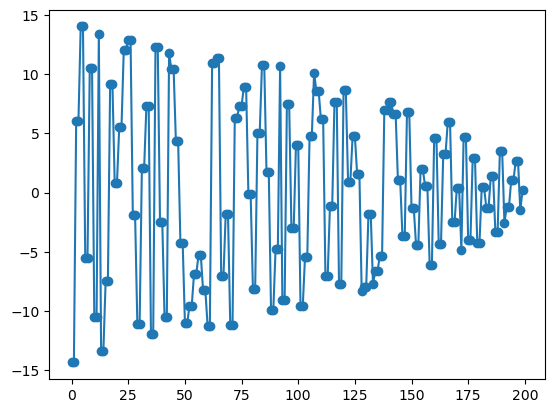

In [11]:
plt.plot(np.linalg.eigvals(compute_X(1, 1, 200, 200, phi_abs, seed=100)), marker='o')

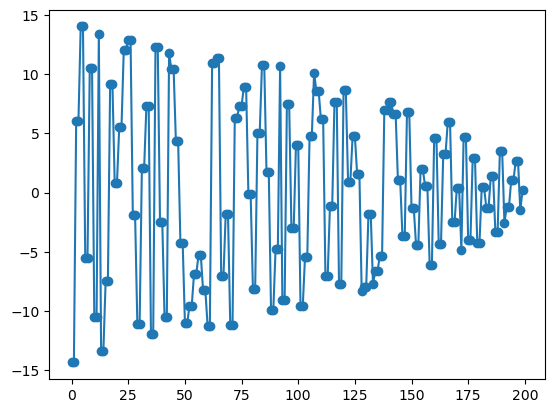

In [13]:
plt.plot(np.linalg.eigvals(compute_X(1, 1, 200, 200, phi_abs, seed=100)), marker='o')

In [14]:
cov_list = []
for λ in range(1, 510, 50):
  for μ in range(1, 510, 50):
    corr_col = np.mean(np.corrcoef(compute_X(λ, μ, 200, 200, phi_abs, seed=100), rowvar=False))
    corr_row = np.mean(np.corrcoef(compute_X(λ, μ, 200, 200, phi_abs, seed=100), rowvar=True))

    cov_list.append({'λ': λ, 'μ': μ, 'corr_col': corr_col, 'corr_row': corr_row})


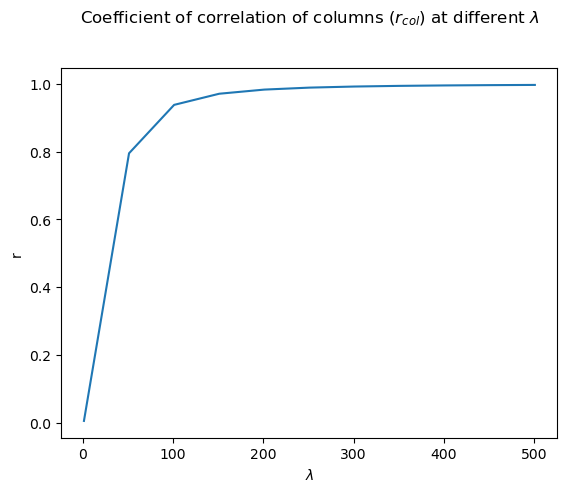

In [15]:
df = pd.DataFrame(cov_list)

df.sort_values(by = 'λ', inplace=True)

plt.plot(df['λ'].unique(),  df[df['μ']==1]['corr_col'])
plt.xlabel(r'$\lambda$')
plt.ylabel('r')
plt.title(r'Coefficient of correlation of columns ($r_{col}$) at different $\lambda$', y=1.1)
plt.show()

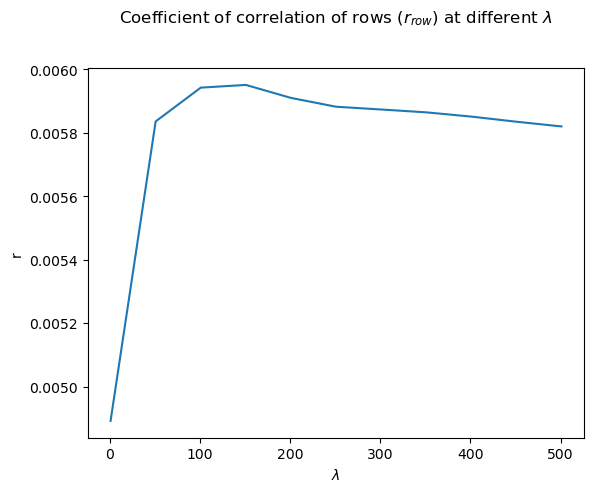

In [16]:
df = pd.DataFrame(cov_list)

df.sort_values(by = 'λ', inplace=True)

plt.plot(df['λ'].unique(),  df[df['μ']==1]['corr_row'])
plt.xlabel(r'$\lambda$')
plt.ylabel('r')
plt.title(r'Coefficient of correlation of rows ($r_{row}$) at different $\lambda$', y=1.1)
plt.show()

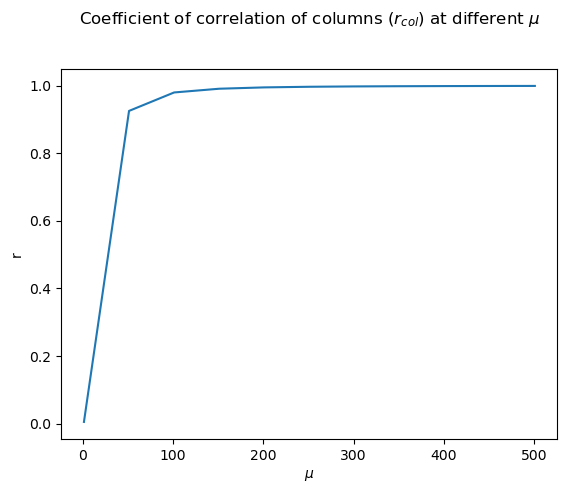

In [17]:
df.sort_values(by = 'μ', inplace=True)

plt.plot(df['μ'].unique(), df[df['λ']==1]['corr_col'])

plt.xlabel(r'$\mu$')
plt.ylabel('r')
plt.title(r'Coefficient of correlation of columns ($r_{col}$) at different $\mu$', y=1.1)
plt.show()

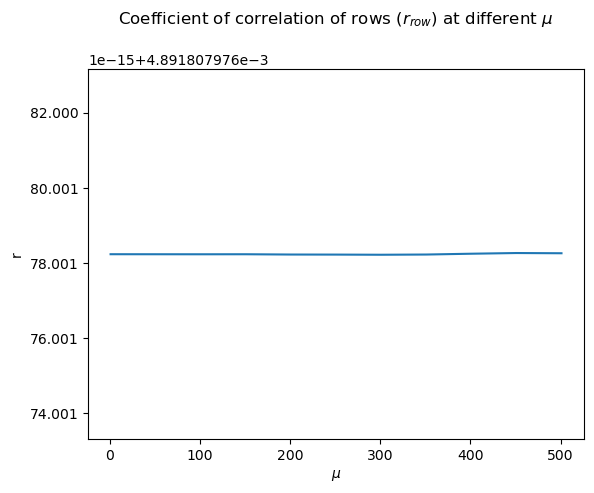

In [18]:
df.sort_values(by = 'μ', inplace=True)

plt.plot(df['μ'].unique(), df[df['λ']==1]['corr_row'])
plt.xlabel(r'$\mu$')
plt.ylabel('r')
plt.title(r'Coefficient of correlation of rows ($r_{row}$) at different $\mu$', y=1.1)
plt.show()